In [136]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings

# Игнорирование предупреждений
warnings.filterwarnings('ignore')


import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
media_wise = pd.read_excel("train.xlsx", sheet_name='data')

In [42]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [43]:
media_wise

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,InvTVReg12,Total12,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,7155663.63,11834254.13,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,8348274.24,13996532.16,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,8348274.24,11466294.66,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,8348274.24,10764632.16,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,8477038.25,10984967.91,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,2024,52,2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
media_wise.dtypes

year                       int64
week                       int64
weekB             datetime64[ns]
SalesRub                 float64
Sales                    float64
                       ...      
InvDigital13             float64
InvSponsorTV13           float64
InvOON13                 float64
InvRadio13               float64
Total13                  float64
Length: 135, dtype: object

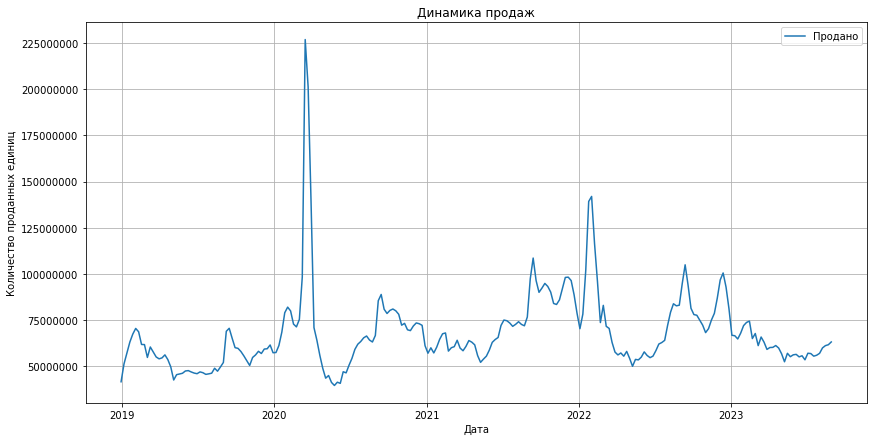

In [45]:
def year_week_to_date(year, week):
    first_day_of_year = datetime.date(year, 1, 1)
    if first_day_of_year.weekday() <= 3:
        first_day_of_year -= datetime.timedelta(days=first_day_of_year.weekday())  
    else:
        first_day_of_year += datetime.timedelta(days=7-first_day_of_year.weekday())
    week_start = first_day_of_year + datetime.timedelta(weeks=week-1)
    return week_start


media_wise['Дата'] = media_wise.apply(lambda row: year_week_to_date(row['year'], row['week']), axis=1)
media_wise = media_wise.sort_values('Дата')


plt.figure(figsize=(14, 7))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(media_wise['Дата'], media_wise['SalesRub'], label='Продано')
plt.title('Динамика продаж')
plt.xlabel('Дата')
plt.ylabel('Количество проданных единиц')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
def plot_rolling(n,year = False, plot_intervals=False, scale=1.96, plot_anomalies=False,acc=[],DATE=media_wise.Дата):
    rolling_mean = acc.rolling(window=n).mean()
    plt.figure(figsize=(16,8))
    plt.grid(True)
    if year:
        plt.plot(DATE,acc[:365].values,label = 'Данные')
        plt.plot(rolling_mean[:365].values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    else:
        plt.plot(DATE,acc.values,label = 'Данные')
        plt.plot(DATE,rolling_mean.values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(acc[n:], rolling_mean[n:])
        deviation = np.std(acc[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = []
            indexes = []
            for i in range(len(acc)):
                if acc[i]<lower_bond[i] or acc[i]>upper_bond[i]:
                    indexes.append(i)
                    anomalies.append(acc[i])
            plt.plot(indexes,anomalies, "ro", markersize=10)
        
    plt.legend()
    plt.show()

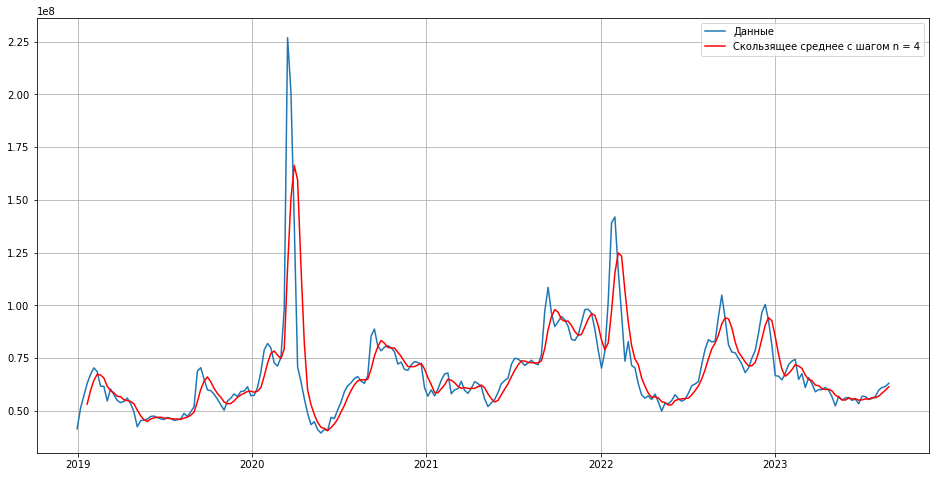

In [47]:
plot_rolling(4,acc=media_wise.SalesRub)

ничего не дает

In [48]:
media_wise 

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,Total12,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,11834254.13,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,13996532.16,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,11466294.66,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,10764632.16,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,10984967.91,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2024,48,2024-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-25
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-02
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-09
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-16



На графике изображена динамика продаж продукта или услуги с течением времени. Вот несколько наблюдений:

Наблюдаются колебания продаж на протяжении всего представленного периода. Это может быть связано с сезонными факторами, изменениями в спросе или влиянием рекламных кампаний.
Есть два выраженных пика продаж: один в 2020 году и один в 2021 году. Пик в 2020 году связан с короной.
После пика в 2020 году наблюдается резкое падение, что может указывать на исчерпание спроса или окончание акции.
В целом, кажется, что в 2022 году продажи стали более стабильными и менее подверженными резким колебаниям, по сравнению с предыдущими годами.
К концу 2022 года и началу 2023 года наблюдается устойчивый тренд на увеличение продаж, который может свидетельствовать о восстановлении спроса, улучшении маркетинговых усилий или позитивном влиянии внешних факторов на рынок.

ADF Statistic (after differencing): -12.445469
p-value (after differencing): 0.000000
Critical Values (after differencing):
	1%: -3.458
	5%: -2.874
	10%: -2.573


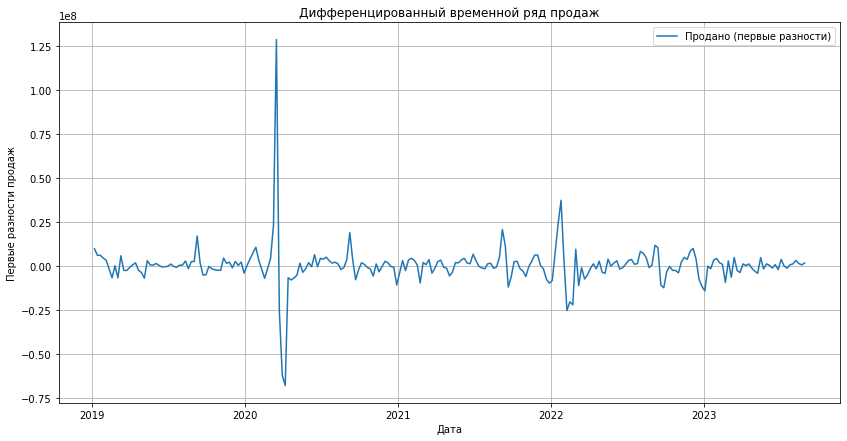

In [49]:
media_wise['Продано_diff'] = media_wise['SalesRub'].diff()

adf_test_result_diff = adfuller(media_wise ['Продано_diff'].dropna())

print("ADF Statistic (after differencing): %f" % adf_test_result_diff[0])
print("p-value (after differencing): %f" % adf_test_result_diff[1])
print("Critical Values (after differencing):")
for key, value in adf_test_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))


plt.figure(figsize=(14, 7))
plt.plot(media_wise['Дата'][1:], media_wise['Продано_diff'][1:], label='Продано (первые разности)')
plt.title('Дифференцированный временной ряд продаж')
plt.xlabel('Дата')
plt.ylabel('Первые разности продаж')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
weeks_to_replace = [12, 13]

filtered_data = media_wise[(media_wise['week'].isin(weeks_to_replace)) & (media_wise['year'] != 2020)]
average_sales = filtered_data.groupby('week')['SalesRub'].mean().to_dict()
media_wise.loc[(media_wise['year'] == 2020) & (media_wise['week'].isin(weeks_to_replace)), 'SalesRub'] = media_wise.loc[(media_wise['year'] == 2020) & (media_wise['week'].isin(weeks_to_replace)), 'week'].map(average_sales)
media_wise[(media_wise['year'] == 2020) & (media_wise['week'].isin(weeks_to_replace))]


,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата,Продано_diff
63,2020,12,2020-03-16,60828150.82,580588.05,0.00,0.00,0.00,0.00,0.00,...,271.89,20.38,7655730.27,0.00,0.00,0.00,0.00,7655730.27,2020-03-16,128593467.50
64,2020,13,2020-03-23,57498727.06,490829.85,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,,0.00,0.00,0.00,0.00,NaN,2020-03-23,-25641497.37


In [282]:
from fbprophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'fbprophet'

In [283]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for cmdstanpy==0.9.5 from https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl.metadata
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for pystan>=2.14 from https://files.pythonhosted.org/packages/d4/d3/4667b1913890108c9d2c46e2cc22cdb6bf20edc6ea910c8d0b8dab622a0e/pystan-3.8.0-py3-none-any.whl.metadata
  Using cached pystan-3.8.0-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for LunarCalendar>=0.0.9 from https://files.pythonhosted.org/packages/ab/e0/a52ffc02395474858552ca6437226e23ad67e25fd85cb387f02e479cfe01/LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Obtaining de

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [343 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  C:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
  C:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  C:\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
    warnings.warn("loaded more than 1 DLL from .libs:"
  --- Logging error ---
  Traceback (most recent call last):
    File "C:\Anaconda\lib\logging\__init__.py", line 1084, in emit
      stream.write(msg + self.terminator)
  ValueError: underlying buffer has been detached
  Call stack:
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
 

In [ ]:
media_wise['weekB'] = pd.to_datetime(df['weekB'])
media_wise.set_index('weekB', inplace=True)

  # Добавьте нужные признаки
X = media_wise[features]
y = media_wise['SalesRub']

# Разделение данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Оценка модели
y_pred = model.predict(X_test_scaled)
print('R2 score:', r2_score(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)) * 100)

# Делаем прогноз на 28 шагов вперед
future_periods = 28
last_X_batch = X[-1:].values  # Возьмем последнее известное значение признаков
last_X_batch_scaled = scaler.transform(last_X_batch)

# Предполагаем, что признаки изменяются аналогично последнему известному периоду
future_X = np.tile(last_X_batch_scaled, (future_periods, 1))
future_predictions = model.predict(future_X)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['SalesRub'], label='Исторические данные')
plt.plot(pd.date_range(df.index[-1], periods=future_periods, freq='W'), future_predictions, label='Прогноз', color='red')
plt.legend()
plt.show()

In [ ]:
+profit или ethna

In [51]:
def adf_test(series, title=''):
    # Очистка данных от бесконечностей и NaN значений
    series_clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    
    print(f'ADF Test: {title}')
    result = adfuller(series_clean, autolag='AIC')  # ADF test
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # Выводим результаты теста ADF
    
    if result[1] <= 0.05:
        print("Стационарный ряд на уровне 5%")
    else:
        print("Нестационарный ряд на уровне 5%")
    print("\n")

    
adf_test(media_wise['SalesRub'].dropna(), 'Продажи')

ADF Test: Продажи
ADF test statistic      -4.81
p-value                  0.00
# lags used              0.00
# observations         243.00
critical value (1%)     -3.46
critical value (5%)     -2.87
critical value (10%)    -2.57
Стационарный ряд на уровне 5%




результаты ADF теста показывают, что временной ряд продаж стационарен на уровне значимости 5%. Это значит, что среднее значение и дисперсия ряда не меняются со временем, и он не требует дифференцирования для достижения стационарности.

In [52]:
media_wise

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата,Продано_diff
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31,NaN
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07,9686718.89
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14,5905062.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21,5913642.03
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28,4295897.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2024,48,2024-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-25,NaN
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-02,NaN
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-09,NaN
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-16,NaN


In [53]:
for column in ['Total1', 'Total2', 'Total3', 'Total4', 'Total5', 'Total6', 'Total7',
               'Total8', 'Total9', 'Total10', 'Total11', 'Total12', 'Total13']:
    media_wise[column].fillna(0, inplace=True)


media_wise[['Total1', 'Total2', 'Total3', 'Total4', 'Total5', 'Total6', 'Total7',
            'Total8', 'Total9', 'Total10', 'Total11', 'Total12', 'Total13']].isnull().sum(), 'Продано_diff' in media_wise.columns

(Total1     0
 Total2     0
 Total3     0
 Total4     0
 Total5     0
 Total6     0
 Total7     0
 Total8     0
 Total9     0
 Total10    0
 Total11    0
 Total12    0
 Total13    0
 dtype: int64,
 True)

In [54]:
non_numeric_columns = ['InvTV', 'InvTV2', 'InvTVReg3', 'TRP4', 'TRP6', 'InvTV6', 'InvTV7', 'InvTV9', 'InvTV12', 'InvTV13']

In [55]:
for column in non_numeric_columns:
    media_wise[column] = pd.to_numeric(media_wise[column], errors='coerce')

In [56]:
non_numeric_columns = media_wise.select_dtypes(exclude=[np.number]).columns.tolist()

print(non_numeric_columns)

['weekB', 'Дата']


In [57]:
nan_columns = ['InvTV', 'InvTV2', 'InvTVReg3', 'TRP4', 'TRP6', 'InvTV6', 'InvTV7', 'InvTV9', 'InvTV12', 'InvTV13']

In [58]:
media_wise[nan_columns] = media_wise[nan_columns].fillna(0)

In [59]:
media_wise_filtered = media_wise[(media_wise['year'] < 2023) | ((media_wise['year'] == 2023) & (media_wise['week'] < 36))]

In [60]:
media_wise_filtered

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата,Продано_diff
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31,NaN
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07,9686718.89
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14,5905062.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21,5913642.03
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28,4295897.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2023,31,2023-07-31,56931505.06,110088.30,415482902.57,243689995.89,122713435.51,29294571.05,412081.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-07-31,1028054.09
240,2023,32,2023-08-07,59881512.89,115345.65,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-07,2950007.83
241,2023,33,2023-08-14,61112178.46,117761.70,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-14,1230665.56
242,2023,34,2023-08-21,61594925.03,118356.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-21,482746.57


In [287]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

df = media_wise_filtered.rename(columns={'weekB': 'ds', 'SalesRub': 'y'})

# Если даты не в формате datetime, конвертируем их
df['ds'] = pd.to_datetime(df['ds'])

# Разделите данные на обучающую и тестовую выборки, если нужно
train = df[:-28]  # Все данные, кроме последних 28 записей
test = df[-28:]   # Последние 28 записей для валидации

# Инициализация и обучение модели
model = Prophet()
model.fit(train)

# Создание будущего DataFrame на 28 периодов вперёд
future = model.make_future_dataframe(periods=28, freq='W')

# Сделать прогноз
forecast = model.predict(future)

# Отображаем график
fig1 = model.plot(forecast)
plt.show()

# Расчёт метрик качества
if len(test) > 0:  # Только если у нас есть тестовые данные
    y_true = test['y'].values
    y_pred = forecast['yhat'][-28:].values
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'R2 Score: {r2}')
    print(f'MAPE: {mape}')

ModuleNotFoundError: No module named 'fbprophet'

In [286]:
! pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for cmdstanpy==0.9.5 from https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl.metadata
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for pystan>=2.14 from https://files.pythonhosted.org/packages/d4/d3/4667b1913890108c9d2c46e2cc22cdb6bf20edc6ea910c8d0b8dab622a0e/pystan-3.8.0-py3-none-any.whl.metadata
  Using cached pystan-3.8.0-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for LunarCalendar>=0.0.9 from https://files.pythonhosted.org/packages/ab/e0/a52ffc02395474858552ca6437226e23ad67e25fd85cb387f02e479cfe01/LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Obtaining de

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [343 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  C:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
  C:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  C:\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
    warnings.warn("loaded more than 1 DLL from .libs:"
  --- Logging error ---
  Traceback (most recent call last):
    File "C:\Anaconda\lib\logging\__init__.py", line 1084, in emit
      stream.write(msg + self.terminator)
  ValueError: underlying buffer has been detached
  Call stack:
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
 

  Obtaining dependency information for pystan>=2.14 from https://files.pythonhosted.org/packages/16/7d/fe5d4cb464497f5a092847b7a7f4f308786981a58fcf0a619e8492057f01/pystan-3.0.0-py3-none-any.whl.metadata
  Using cached pystan-3.0.0-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for pystan>=2.14 from https://files.pythonhosted.org/packages/e3/7b/ba001a1e29e297a033c6a110ab80914bc4a2ed0a1aaec4c0224d56dfbbfe/pystan-2.19.1.1-cp38-cp38-win_amd64.whl.metadata
  Using cached pystan-2.19.1.1-cp38-cp38-win_amd64.whl.metadata (5.9 kB)
Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
Using cached pystan-2.19.1.1-cp38-cp38-win_amd64.whl (79.8 MB)
Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
Using cached ephem-4.1.5-cp38-cp38-win_amd64.whl (1.4 MB)
  Running setup.py clean for fbprophet
Failed to build fbprophet



    File "<frozen importlib._bootstrap>", line 961, in _find_and_load_unlocked
    File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
    File "<frozen importlib._bootstrap>", line 991, in _find_and_load
    File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked
    File "<frozen importlib._bootstrap>", line 671, in _load_unlocked
    File "<frozen importlib._bootstrap_external>", line 783, in exec_module
    File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
    File "C:\Anaconda\lib\site-packages\pandas\core\ops\__init__.py", line 33, in <module>
      from pandas.core.ops.array_ops import (  # noqa:F401
    File "<frozen importlib._bootstrap>", line 991, in _find_and_load
    File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked
    File "<frozen importlib._bootstrap>", line 671, in _load_unlocked
    File "<frozen importlib._bootstrap_external>", line 783, in exec_module
    File "<frozen 

In [114]:
media_wise_filtered.dtypes

year                     int64
week                     int64
weekB           datetime64[ns]
SalesRub               float64
Sales                  float64
                     ...      
InvOON13               float64
InvRadio13             float64
Total13                float64
Дата                    object
Продано_diff           float64
Length: 137, dtype: object

## ПОСТРОИМ МАТРИЦУ КОРРЕЛЯЦИЙ

In [115]:
correlation_matrix = media_wise_filtered.corr()
correlated_features = correlation_matrix.index[correlation_matrix["SalesRub"] > 0.2].tolist()
correlated_features.remove('SalesRub') if 'SalesRub' in correlated_features else correlated_features


correlated_features

['year',
 'Sales',
 'SalesRubMonth',
 'R1',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'Distribution',
 'Morbidity',
 'InvDigiral',
 'Wordstat',
 'InvDigital1',
 'InvSponsorTV1',
 'InvDigital5',
 'Total5',
 'TRP6',
 'CoverageTV6',
 'InvTV6',
 'InvDigital6',
 'Total6',
 'InvTV7',
 'InvOON7',
 'Total7',
 'TRP9',
 'CoverageTV9',
 'InvTV9',
 'InvTVReg9',
 'Total9',
 'InvDigital10',
 'Total10',
 'InvDigital11',
 'TRP12',
 'CoverageTV12',
 'InvTV12',
 'Total12',
 'TRP13',
 'CoverageTV13',
 'InvDigital13',
 'InvRadio13',
 'Total13']

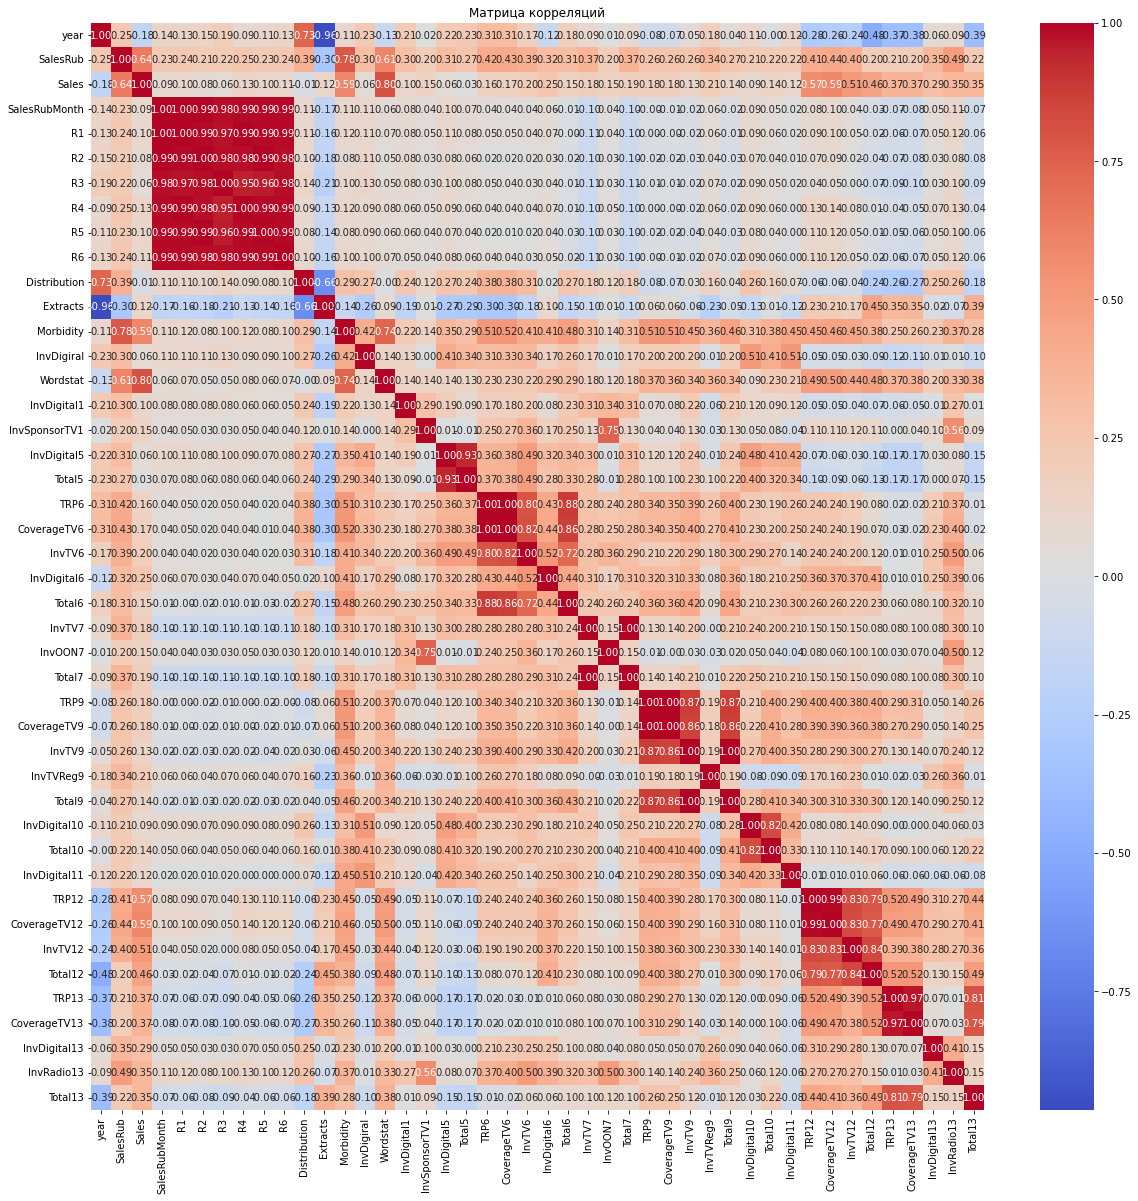

In [116]:
correlation_matrix = media_wise_filtered.corr()
features_high_correlation = correlation_matrix.index[abs(correlation_matrix["SalesRub"]) > 0.2].tolist()
selected_correlation_matrix = correlation_matrix.loc[features_high_correlation, features_high_correlation]

plt.figure(figsize=(20, 20))
sns.heatmap(selected_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Матрица корреляций')
plt.show()

In [117]:
import pandas as pd

# Предположим, что media_wise_filtered - это ваш исходный DataFrame
correlation_matrix = media_wise_filtered.corr()

# Отбор признаков с корреляцией больше 0.1 по модулю с SalesRub
features_high_correlation = correlation_matrix.index[abs(correlation_matrix["SalesRub"]) > 0.1].tolist()

# Всегда включаем 'SalesRub' и другие важные столбцы в список
mandatory_columns = ['SalesRub', 'year', 'week', 'weekB']  # Список обязательных столбцов
features_high_correlation.extend(mandatory_columns)  # Добавляем обязательные столбцы
features_high_correlation = list(set(features_high_correlation))  # Удаляем возможные дубликаты

# Создание нового DataFrame только с выбранными признаками
media_wise_selected = media_wise_filtered[features_high_correlation]

# Вывод информации о новом DataFrame
print(media_wise_selected.info())
print("Новый датасет успешно создан и содержит только отобранные признаки с корреляцией > 0.1.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 71 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              244 non-null    int64         
 1   Morbidity         244 non-null    float64       
 2   InvTVReg5         244 non-null    float64       
 3   SalesRub          244 non-null    float64       
 4   InvTVReg3         244 non-null    float64       
 5   Total3            244 non-null    float64       
 6   InvTV12           244 non-null    float64       
 7   Wordstat          244 non-null    float64       
 8   Distribution      244 non-null    float64       
 9   InvDigiral        244 non-null    float64       
 10  TRP8              244 non-null    float64       
 11  InvOON7           244 non-null    float64       
 12  InvTV             244 non-null    float64       
 13  InvDigital1       244 non-null    float64       
 14  TRP12             244 non-

In [118]:
columns_to_drop = ['Sales', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'Продано_diff']
media_wise_selected.drop(columns=columns_to_drop, errors='ignore', inplace = True)

C:\Users\Юля\AppData\Local\Temp\ipykernel_5288\1998721414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  media_wise_selected.drop(columns=columns_to_drop, errors='ignore', inplace = True)


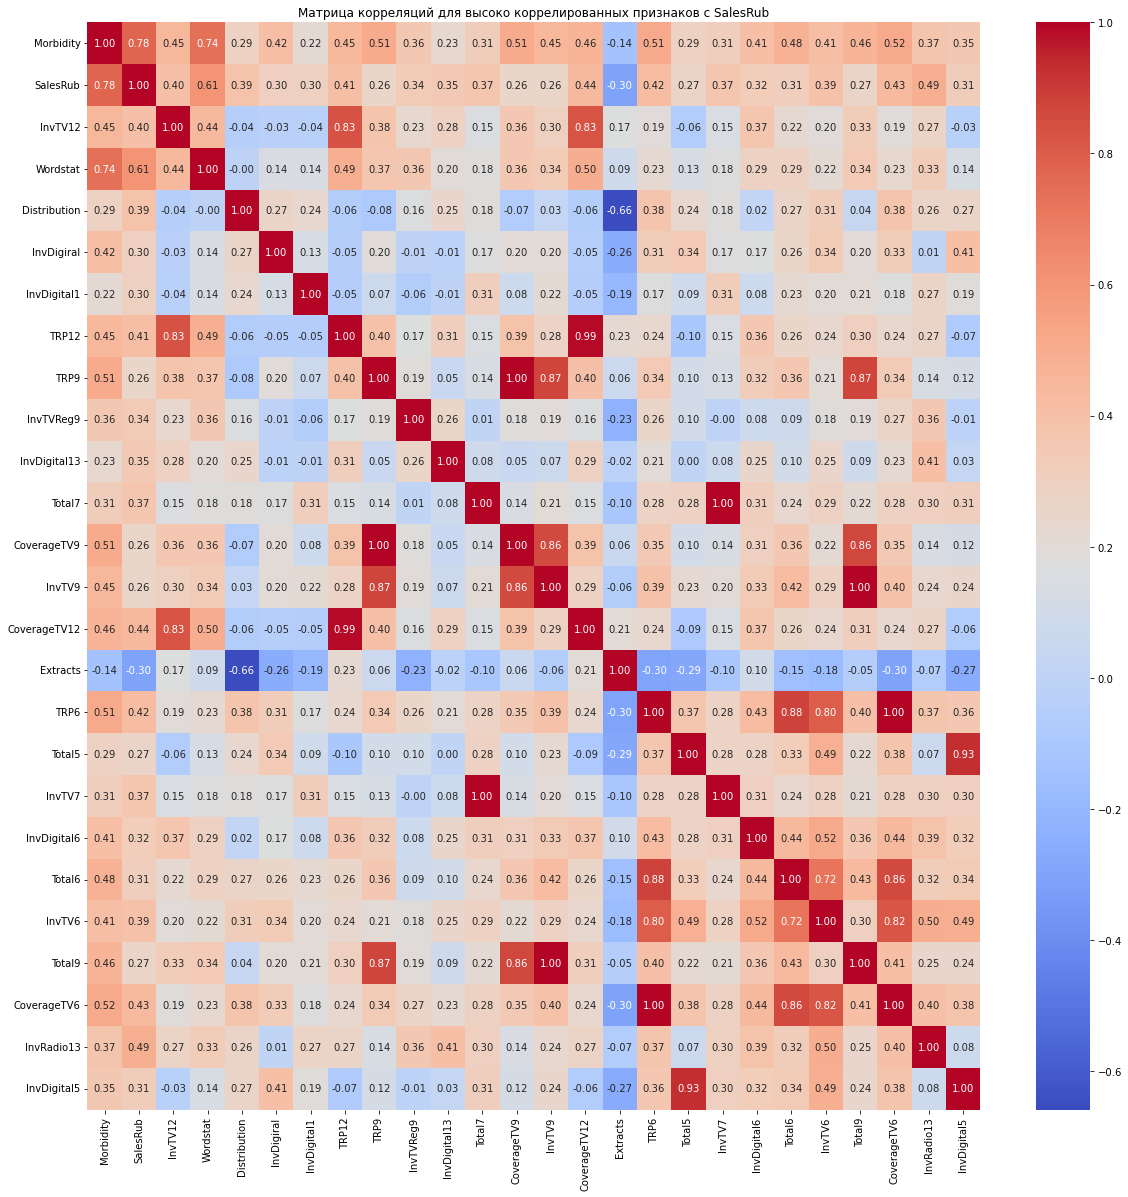

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Пересчитываем корреляционную матрицу для уже отобранных признаков
correlation_matrix = media_wise_selected.corr()

# Создаем булев индекс для признаков, которые имеют корреляцию больше 0.3 по модулю с SalesRub
high_corr_index = correlation_matrix["SalesRub"].abs() > 0.25

# Фильтруем индексы, удовлетворяющие условию выше
features_high_correlation = correlation_matrix.index[high_corr_index].tolist()

# Создаем корреляционную матрицу только для отобранных признаков
selected_correlation_matrix = correlation_matrix.loc[features_high_correlation, features_high_correlation]

# Визуализация корреляционной матрицы
plt.figure(figsize=(20, 20))
sns.heatmap(selected_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Матрица корреляций для высоко коррелированных признаков с SalesRub')
plt.show()


### Отбор X и Y

In [260]:
columns_to_drop = ['SalesRub', 'year', 'week', 'weekB', 'Sales', 'SalesRubMonth', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'Дата','Продано_diff']
X = media_wise_selected.drop(columns=columns_to_drop, errors='ignore')
Y = media_wise_selected['SalesRub'].dropna()

In [261]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [262]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [267]:
def timeseries_train_test_split(X, Y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = Y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = Y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [268]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, Y, test_size=0.2)

In [269]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler



In [270]:
lasso = LassoCV(cv=tscv, alphas=np.logspace(-6, 2, 100), max_iter=100000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
# Подготовка данных: масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

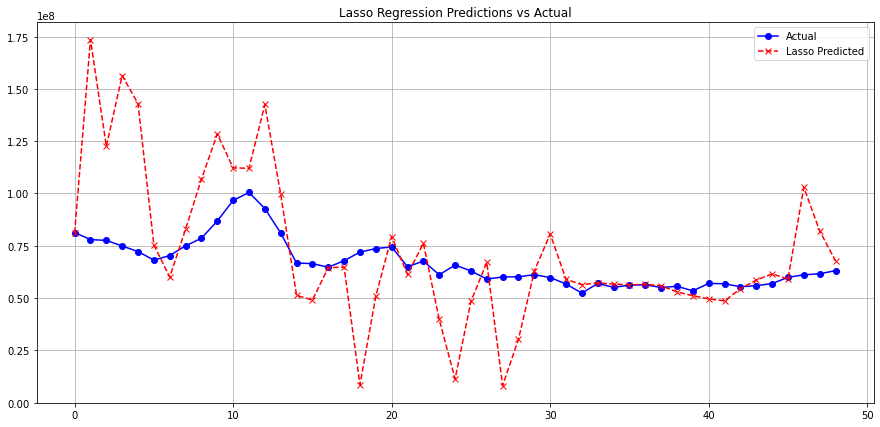

Mean Absolute Percentage Error (MAPE): 0.27%


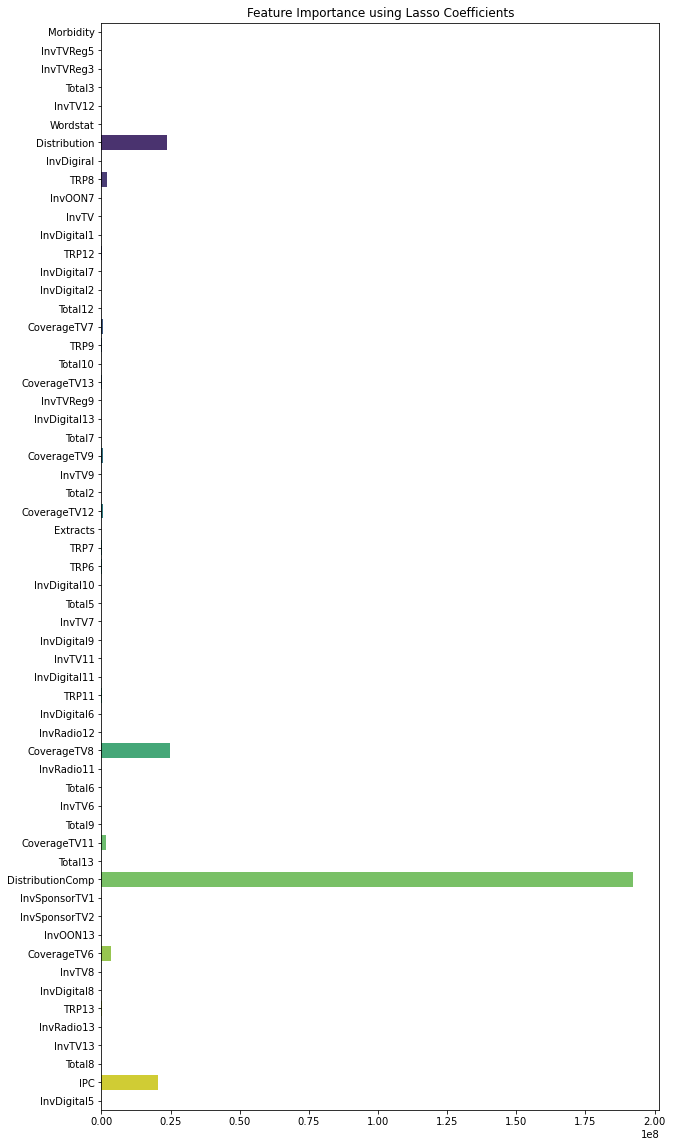

In [271]:
# 2. Визуализация результатов предсказания
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_lasso, label='Lasso Predicted', color='red', linestyle='--', marker='x')
plt.title('Lasso Regression Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Расчет MAPE
mape = mean_absolute_percentage_error(y_test, y_pred_lasso)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# 3. Отображение важности признаков
lasso_coefs = np.abs(lasso.coef_)
features = X_train.columns

plt.figure(figsize=(10, 20))
sns.barplot(y=features, x=lasso_coefs, palette='viridis')
plt.title('Feature Importance using Lasso Coefficients')
plt.show()

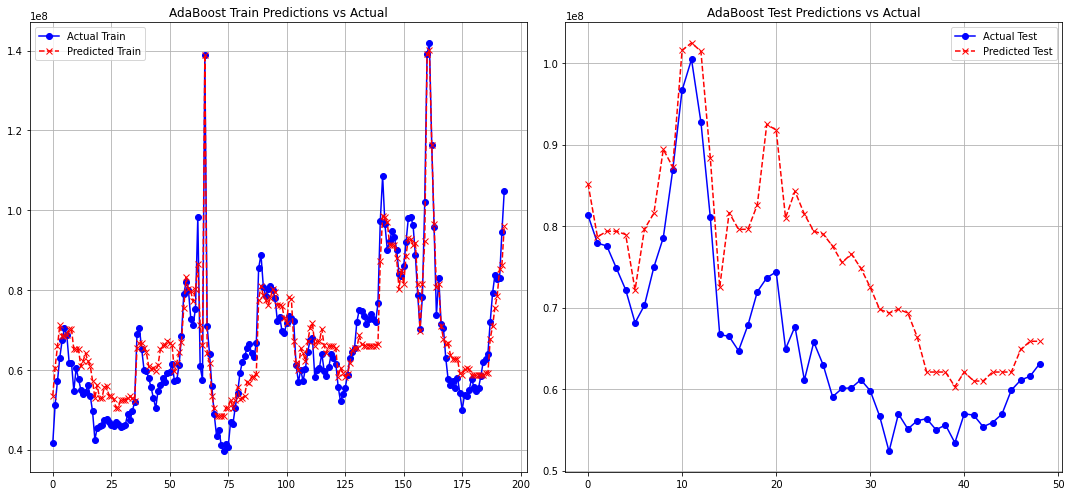

Train R^2: 0.856
Test R^2: 0.525
Train MAPE: 0.07%
Test MAPE: 0.12%
Test MAE: 7716853.14
Test MSE: 78726853591801.33


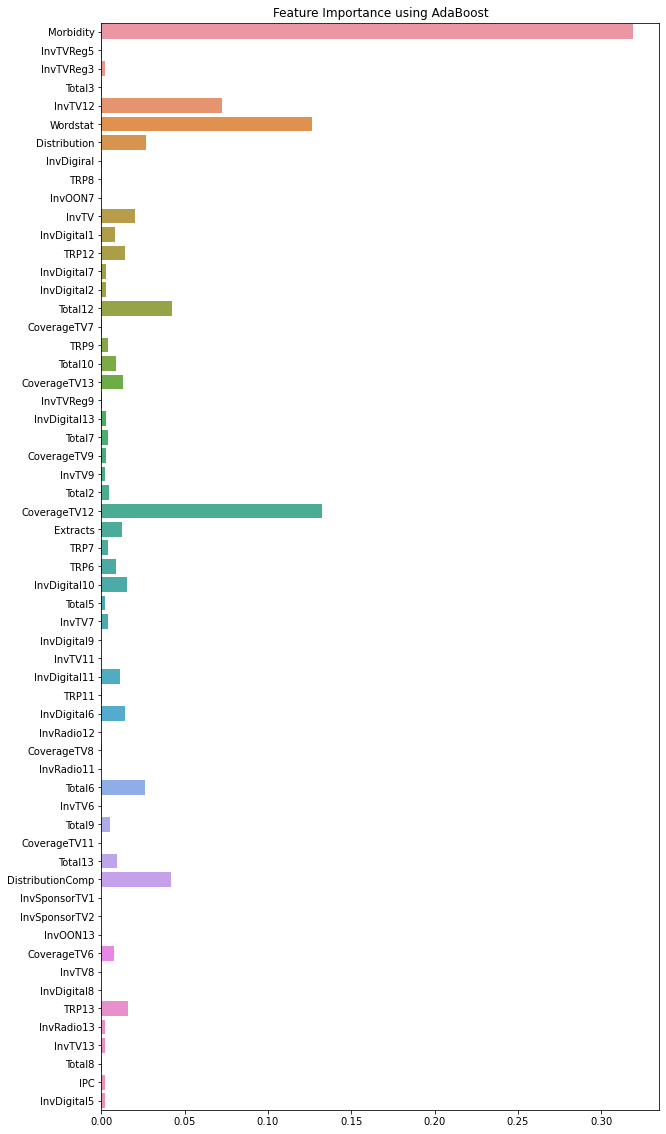

In [272]:
# Обучение AdaBoostRegressor
gbr = AdaBoostRegressor(n_estimators=100, random_state=0)
gbr.fit(X_train_scaled, y_train)

y_pred_train = gbr.predict(X_train_scaled)
y_pred_test = gbr.predict(X_test_scaled)

# Визуализация результатов предсказания для обучающего набора
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # Первый подграфик для тренировочных данных
plt.plot(y_train.values, label='Actual Train', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_train, label='Predicted Train', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Train Predictions vs Actual')
plt.legend()
plt.grid(True)

# Визуализация результатов предсказания для тестового набора
plt.subplot(1, 2, 2)  # Второй подграфик для тестовых данных
plt.plot(y_test.values, label='Actual Test', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_test, label='Predicted Test', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Test Predictions vs Actual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод метрик
print(f'Train R^2: {r2_train:.3f}')
print(f'Test R^2: {r2_test:.3f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
print(f'Test MAE: {mae_test:.2f}')
print(f'Test MSE: {mse_test:.2f}')

# Вывод важности признаков
feature_importances = gbr.feature_importances_
plt.figure(figsize=(10, 20))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importance using AdaBoost')
plt.show()

In [ ]:
etpna

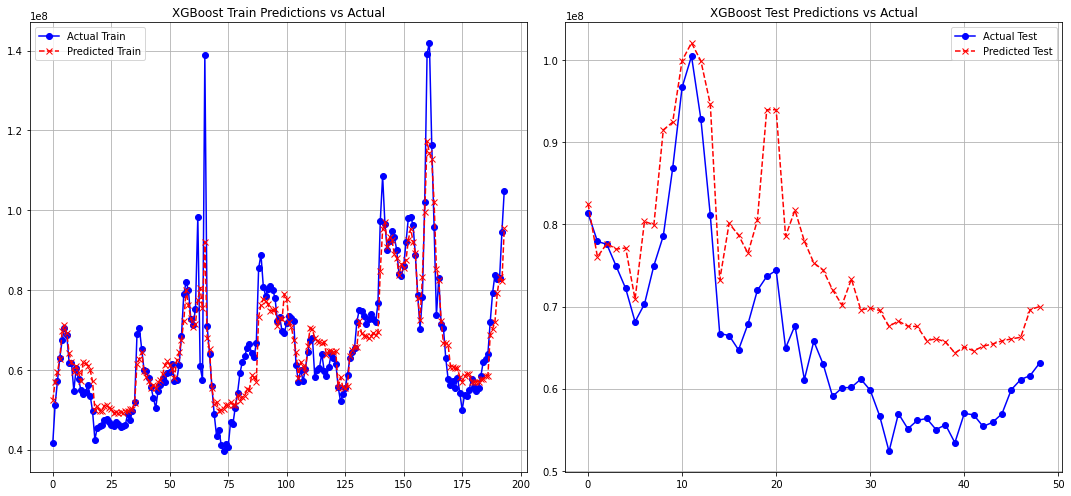

Train R^2: 0.844
Test R^2: 0.169
Train MAPE: 0.07%
Test MAPE: 0.15%
Test MAE: 9352795.02
Test MSE: 107955089585976.84


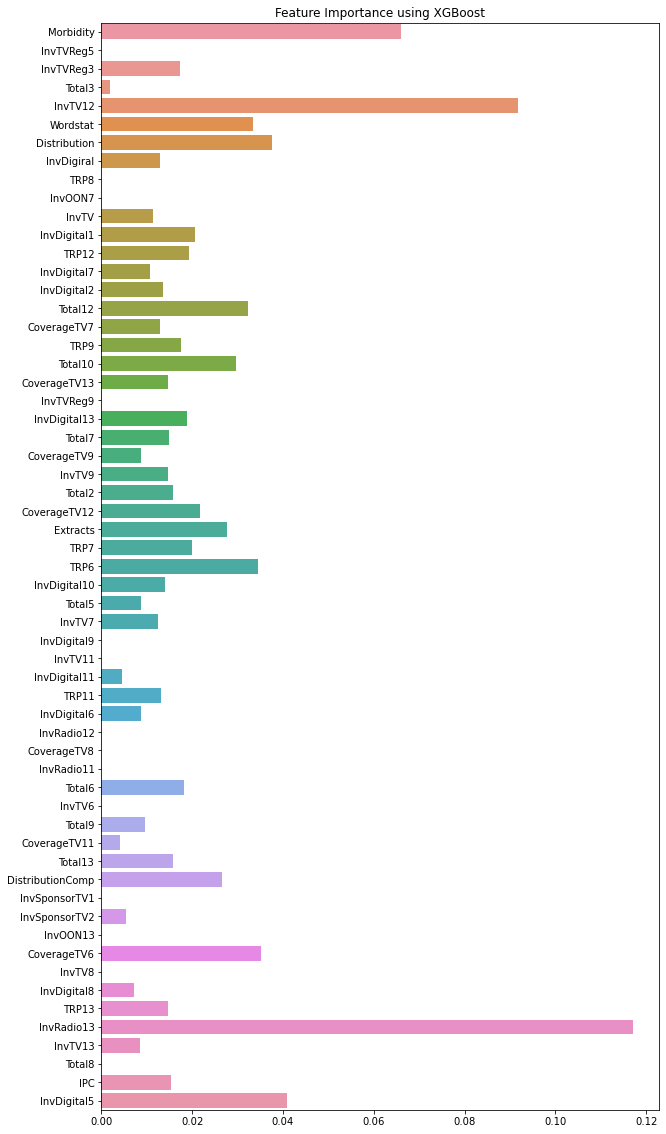

In [273]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных: масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


params = {
    'n_estimators': 500,
    'learning_rate': 0.007,
    'max_depth': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 4,
    'lambda': 1,
    'alpha': 0.5,
    'random_state': 0
} 
# Создание и обучение модели XGBoost
model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled, y_train)

# Предсказание значений на обучающем и тестовом наборах
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Визуализация результатов предсказания
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # Тренировочные данные
plt.plot(y_train.values, label='Actual Train', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_train, label='Predicted Train', color='red', linestyle='--', marker='x')
plt.title('XGBoost Train Predictions vs Actual')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  # Тестовые данные
plt.plot(y_test.values, label='Actual Test', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_test, label='Predicted Test', color='red', linestyle='--', marker='x')
plt.title('XGBoost Test Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Расчет метрик
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Train R^2: {r2_train:.3f}')
print(f'Test R^2: {r2_test:.3f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
print(f'Test MAE: {mae_test:.2f}')
print(f'Test MSE: {mse_test:.2f}')

# Вывод важности признаков
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 20))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importance using XGBoost')
plt.show()

In [274]:
importance_dict_xgb = dict(zip(X_train.columns, model.feature_importances_))
importance_dict_adaboost = dict(zip(X_train.columns, gbr.feature_importances_))
importance_dict_corr = correlation_matrix['SalesRub'].drop('SalesRub').to_dict()


feature_importance_df = pd.DataFrame(index=X_train.columns)
feature_importance_df['XGB Importance'] = feature_importance_df.index.map(importance_dict_xgb)
feature_importance_df['AdaBoost Importance'] = feature_importance_df.index.map(importance_dict_adaboost)
feature_importance_df['Correlation With SalesRub'] = feature_importance_df.index.map(importance_dict_corr)


threshold_importance = 0.01  
threshold_corr = 0.25


important_features_df = feature_importance_df[
    (feature_importance_df['XGB Importance'] >= threshold_importance) &
    (feature_importance_df['AdaBoost Importance'] >= threshold_importance) &
    (feature_importance_df['Correlation With SalesRub'].abs() > threshold_corr)
]

important_features_df

,XGB Importance,AdaBoost Importance,Correlation With SalesRub
Morbidity,0.07,0.32,0.78
InvTV12,0.09,0.07,0.40
Wordstat,0.03,0.13,0.61
Distribution,0.04,0.03,0.39
TRP12,0.02,0.01,0.41
CoverageTV12,0.02,0.13,0.44
Extracts,0.03,0.01,-0.30
Total6,0.02,0.03,0.31


In [277]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Загрузите ваши данные здесь. Например:
# X_train - ваши тренировочные данные
# y_train - целевые значения для тренировочных данных
# X должен быть уже преобразован в трехмерный массив для LSTM [samples, timesteps, features].

# Масштабирование данных для улучшения обучения модели
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))

# Изменение формы данных для обучения LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=0)

# Подготовка последнего доступного входного набора данных для прогнозирования
last_input = X_train_scaled[-1]
last_input = last_input.reshape((1, 1, last_input.shape[1]))

# Прогнозирование на 28 шагов вперед
predicted = []
for _ in range(28):
    pred = model.predict(last_input, verbose=0)
    predicted.append(pred[0, 0])
    last_input = np.append(last_input[:, :, 1:], pred).reshape(1, 1, last_input.shape[2])

# Преобразование прогнозов обратно в исходный масштаб
predicted = scaler_Y.inverse_transform(np.array(predicted).reshape(-1, 1))

# Визуализация исторических данных и прогнозов
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Исторические данные')
plt.plot(np.arange(len(y_train), len(y_train) + 28), predicted, label='Прогноз', color='red')
plt.legend()
plt.show()


AttributeError: 'Series' object has no attribute 'reshape'

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error


# Разделение данных на обучающую и тестовую выборки
#train_size = int(len(X) * 0.8)
#X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
#y_train, y_test = Y.iloc[:train_size], Y.iloc[train_size:]

# Масштабирование данных
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_Y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.to_numpy().reshape(-1, 1))

# Создание модели LSTM с регуляризацией
model = Sequential([
    LSTM(200, activation='relu', input_shape=(X_train_scaled.shape[1], 1), 
         return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),
    LSTM(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),
    Dense(1)
])
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Обучение модели
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=1, verbose=1)

# Функция для выполнения рекурсивного прогнозирования
def recursive_forecast(model, last_known_batch, n_periods):
    predictions = []
    current_batch = last_known_batch
    for _ in range(n_periods):
        y_pred_scaled = model.predict(current_batch[np.newaxis, :, np.newaxis])
        y_pred = scaler_Y.inverse_transform(y_pred_scaled)
        predictions.append(y_pred[0, 0])
        current_batch = np.roll(current_batch, -1)
        current_batch[-1] = y_pred_scaled[0, 0]
    return predictions

# Выполнение прогноза
last_known_batch = X_test_scaled[-1]
predictions = recursive_forecast(model, last_known_batch, 28)

# Оценка модели
y_pred_train_scaled = model.predict(X_train_scaled)
y_pred_train = scaler_Y.inverse_transform(y_pred_train_scaled)
r2 = r2_score(y_train, y_pred_train)
mape = mean_absolute_percentage_error(y_train, y_pred_train)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_train)), y_train, label='Исторические данные')
plt.plot(np.arange(len(y_train), len(y_train) + 28), predictions, label='Прогноз', color='red')
plt.title(f'R2: {r2:.2f}, MAPE: {mape:.2%}')
plt.legend()
plt.show()


Epoch 1/50
194/194 [==============================] - 8s 24ms/step - loss: 93685257601024.0000
Epoch 2/50
194/194 [==============================] - 3s 17ms/step - loss: 4.1903
Epoch 3/50
194/194 [==============================] - 3s 17ms/step - loss: 2815.2527
Epoch 4/50
194/194 [==============================] - 3s 17ms/step - loss: 5.1995
Epoch 5/50
194/194 [==============================] - 3s 18ms/step - loss: 5.0601
Epoch 6/50
194/194 [==============================] - 3s 18ms/step - loss: 5.0876
Epoch 7/50
194/194 [==============================] - 3s 18ms/step - loss: 4.9540
Epoch 8/50
194/194 [==============================] - 3s 17ms/step - loss: 4.8610
Epoch 9/50
194/194 [==============================] - 3s 17ms/step - loss: 4.7881
Epoch 10/50
194/194 [==============================] - 3s 18ms/step - loss: 4.7220
Epoch 11/50
194/194 [==============================] - 3s 18ms/step - loss: 4.6668
Epoch 12/50
194/194 [==============================] - 3s 18ms/step - loss: 4.61

TypeError: in user code:

    File "C:\Anaconda\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Anaconda\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Anaconda\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Anaconda\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Anaconda\lib\site-packages\keras\src\layers\rnn\lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_9' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_9' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


## НЕЙРОСЕТЬ

Epoch 1/50
195/195 [==============================] - 4s 10ms/step - loss: 0.9147
Epoch 2/50
195/195 [==============================] - 2s 10ms/step - loss: 31616242.0000
Epoch 3/50
195/195 [==============================] - 2s 9ms/step - loss: 0.8305
Epoch 4/50
195/195 [==============================] - 2s 8ms/step - loss: 66.7630
Epoch 5/50
195/195 [==============================] - 2s 8ms/step - loss: 0.7763
Epoch 6/50
195/195 [==============================] - 2s 9ms/step - loss: 0.7766
Epoch 7/50
195/195 [==============================] - 1s 7ms/step - loss: 0.7756
Epoch 8/50
195/195 [==============================] - 1s 7ms/step - loss: 0.7644
Epoch 9/50
195/195 [==============================] - 1s 7ms/step - loss: 0.7806
Epoch 10/50
195/195 [==============================] - 2s 8ms/step - loss: 0.7531
Epoch 11/50
195/195 [==============================] - 2s 8ms/step - loss: 0.7382
Epoch 12/50
195/195 [==============================] - 1s 7ms/step - loss: 0.7323
Epoch 13/50
195

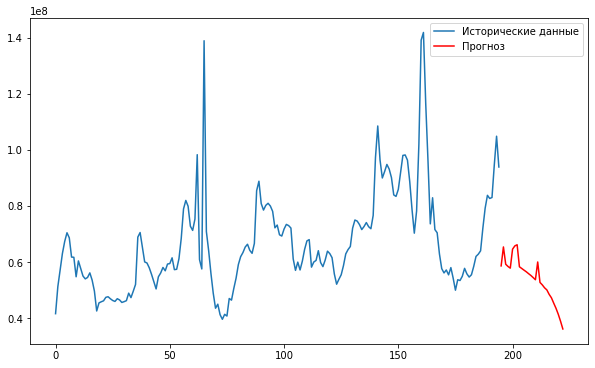

In [235]:
# Предположим, df - это ваш исходный DataFrame с данными.
X = X['Morbidity', 'InvTV12', 'Wordstat', 'Distribution', 'TRP12',
            'Total7', 'CoverageTV12', 'Extracts', 'TRP6', 'Total6', 'InvRadio13']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Масштабирование данных.
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_Y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.to_numpy().reshape(-1, 1))

# LSTM ожидает данные в формате [samples, time steps, features].
# Предполагается, что X уже содержит временные шаги в правильном формате.

# Создание модели LSTM.
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели.
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=1, verbose=1)

# Функция для выполнения рекурсивного прогнозирования.
def recursive_forecast(model, last_known_batch, n_periods, scaler_X, scaler_Y):
    predictions = []
    current_batch = last_known_batch
    for _ in range(n_periods):
        y_pred_scaled = model.predict(current_batch[np.newaxis, :, np.newaxis])
        y_pred = scaler_Y.inverse_transform(y_pred_scaled)
        predictions.append(y_pred[0, 0])
        current_batch = np.roll(current_batch, -1)
        current_batch[-1] = y_pred_scaled
    return predictions

# Подготовка последнего известного батча данных.
last_known_batch = X_test_scaled[-1]

# Выполнение прогноза на 28 периодов вперёд.
predictions = recursive_forecast(model, last_known_batch, 28, scaler_X, scaler_Y)

# Визуализация результатов.
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_train)), y_train, label='Исторические данные')
plt.plot(np.arange(len(y_train), len(y_train) + 28), predictions, label='Прогноз', color='red')
plt.legend()
plt.show()

In [255]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Фиксируем зерно для воспроизводимости результатов
np.random.seed(7)
tf.random.set_seed(7)

# Загрузите ваш набор данных
# data = pd.read_csv('your_data.csv')

# Предположим, что `data` это ваш DataFrame и `X` и `Y` это данные признаков и целевые переменные соответственно
# X = data.drop(columns=['target'])
# Y = data['target']

# Допустим, у вас уже есть разделенные данные:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# Важно: Убедитесь, что X_train и X_test уже содержат временные шаги в правильном формате для LSTM.
# Если это не так, то необходимо будет преобразовать данные соответствующим образом.

# Масштабирование данных
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))

# Подготовка данных для LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Функция создания модели LSTM для Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                   activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='mean_squared_error')
    return model

# Используем RandomSearch для оптимизации гиперпараметров
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_optimization'
)

# Обучаем модели
tuner.search(
    X_train_scaled, y_train_scaled,
    epochs=100, # Или сколько потребуется
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Получение оптимальных гиперпараметров
best_hps = tuner.get_best_hyperparameters()[0]

# Создание и обучение модели с лучшими параметрами
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))

# Функция для рекурсивного прогнозирования
def recursive_forecast(model, X_test_scaled, n_periods, scaler_Y):
    predictions = []
    current_batch = X_test_scaled[-1]
    for _ in range(n_periods):
        y_pred_scaled = model.predict(current_batch[np.newaxis, :, :])
        y_pred = scaler_Y.inverse_transform(y_pred_scaled)[0][0]
        predictions.append(y_pred)
        current_batch = np.roll(current_batch, -1)
        current_batch[-1] = y_pred_scaled
    return predictions

# Делаем прогноз на 28 периодов вперед
predictions = recursive_forecast(model, X_test_scaled, 28, scaler_Y)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Исторические данные')
plt.plot(np.arange(len(y_train), len(y_train) + 28), predictions, label='Прогноз')
plt.legend()
plt.show()


FailedPreconditionError: my_dir\lstm_optimization is not a directory

In [251]:
!pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   -------------------------------------- 129.1/129.1 kB 951.3 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Лассо

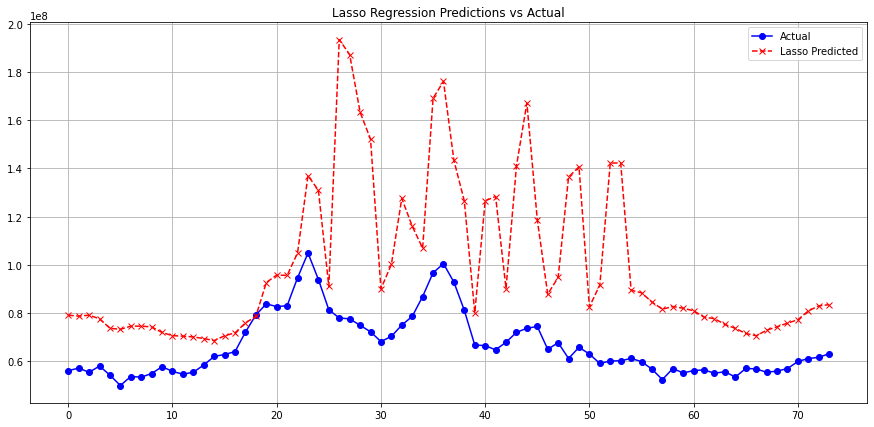

Mean Absolute Percentage Error (MAPE): 0.49%


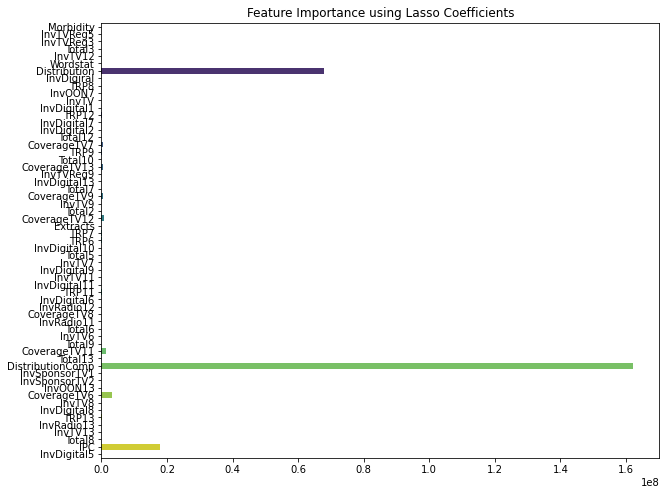

In [137]:

# 1. Обучение Lasso регрессии
tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv, alphas=np.logspace(-6, 2, 100), max_iter=100000)
lasso.fit(X_train, y_train)

# Предсказание значений на тестовом наборе
y_pred_lasso = lasso.predict(X_test)

# 2. Визуализация результатов предсказания
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_lasso, label='Lasso Predicted', color='red', linestyle='--', marker='x')
plt.title('Lasso Regression Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Расчет MAPE
mape = mean_absolute_percentage_error(y_test, y_pred_lasso)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# 3. Отображение важности признаков
lasso_coefs = np.abs(lasso.coef_)
features = X_train.columns

plt.figure(figsize=(10, 8))
sns.barplot(y=features, x=lasso_coefs, palette='viridis')
plt.title('Feature Importance using Lasso Coefficients')
plt.show()



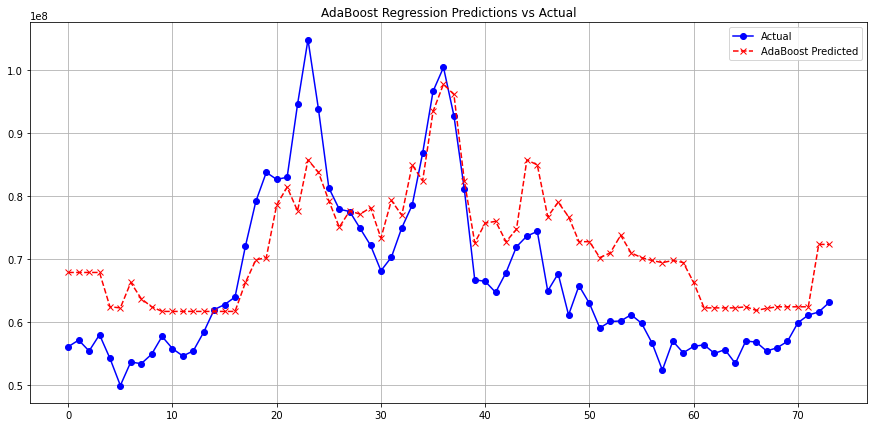

Train R^2: 0.903
Test R^2: 0.519
Train MAPE: 0.08%
Test MAPE: 0.12%
Test MAE: 7767401.02
Test MSE: 79700309953609.16


In [138]:
# Подготовка данных: масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение AdaBoostRegressor
gbr = AdaBoostRegressor(n_estimators=100, random_state=0)
gbr.fit(X_train_scaled, y_train)

# Предсказание значений на тестовом наборе
y_pred_train = gbr.predict(X_train_scaled)
y_pred_test = gbr.predict(X_test_scaled)

# Визуализация результатов предсказания
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_test, label='AdaBoost Predicted', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Regression Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Расчет метрик
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Train R^2: {r2_train:.3f}')
print(f'Test R^2: {r2_test:.3f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
print(f'Test MAE: {mae_test:.2f}')
print(f'Test MSE: {mse_test:.2f}')


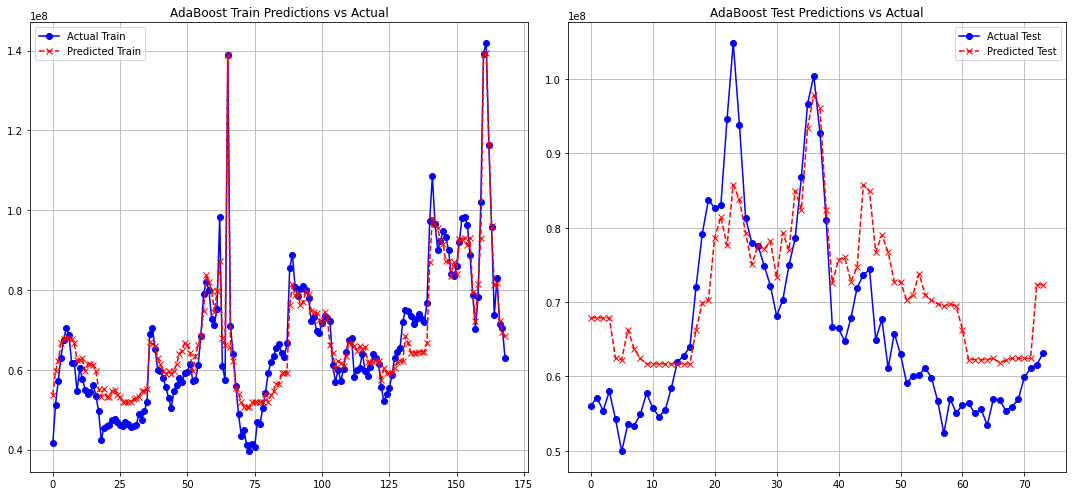

Train R^2: 0.903
Test R^2: 0.519
Train MAPE: 0.08%
Test MAPE: 0.12%
Test MAE: 7767401.02
Test MSE: 79700309953609.16


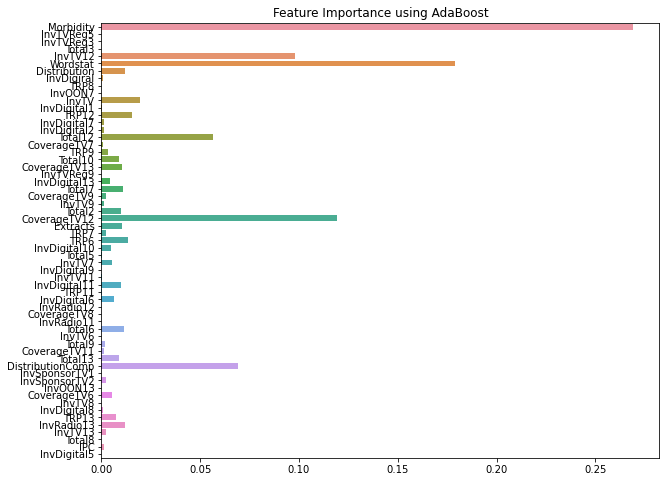

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Подготовка данных: масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение AdaBoostRegressor
gbr = AdaBoostRegressor(n_estimators=100, random_state=0)
gbr.fit(X_train_scaled, y_train)

# Предсказание значений на тренировочном и тестовом наборах
y_pred_train = gbr.predict(X_train_scaled)
y_pred_test = gbr.predict(X_test_scaled)

# Визуализация результатов предсказания для обучающего набора
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # Первый подграфик для тренировочных данных
plt.plot(y_train.values, label='Actual Train', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_train, label='Predicted Train', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Train Predictions vs Actual')
plt.legend()
plt.grid(True)

# Визуализация результатов предсказания для тестового набора
plt.subplot(1, 2, 2)  # Второй подграфик для тестовых данных
plt.plot(y_test.values, label='Actual Test', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_test, label='Predicted Test', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Test Predictions vs Actual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод метрик
print(f'Train R^2: {r2_train:.3f}')
print(f'Test R^2: {r2_test:.3f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
print(f'Test MAE: {mae_test:.2f}')
print(f'Test MSE: {mse_test:.2f}')

# Вывод важности признаков
feature_importances = gbr.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importance using AdaBoost')
plt.show()



In [184]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import shap

# Предположим, что media_wise_filtered уже загружен и содержит все необходимые данные
# Определение столбцов для удаления
columns_to_drop = ['SalesRub', 'year', 'week', 'weekB', 'Sales', 'SalesRubMonth', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6']
X = media_wise_filtered.drop(columns=columns_to_drop, errors='ignore')
Y = media_wise_filtered['SalesRub'].dropna()

# Исправление нечисловых данных и заполнение пропусков
X = X.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Обучение RandomForest для вычисления SHAP значений
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, Y)

# Создание SHAP explainer и получение значений
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_imputed)

# Сортировка признаков по важности SHAP и выбор топ-20
shap_importance = pd.DataFrame(list(zip(X.columns, np.abs(shap_values).mean(0))),
                               columns=['Feature', 'SHAP Importance'])
shap_importance.sort_values(by='SHAP Importance', ascending=False, inplace=True)
top_features = shap_importance.head(20)['Feature'].values

# Фильтрация X для использования только топ-20 признаков
X_top = X_imputed[top_features]

# Добавление константы для учета свободного члена в модели
X_top_with_const = sm.add_constant(X_top)

# Построение и обучение GLM
glm = sm.GLM(Y, X_top_with_const, family=sm.families.Gaussian()).fit()

# Вывод результатов
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      223
Model Family:                Gaussian   Df Model:                           20
Link Function:               identity   Scale:                      1.1486e+14
Method:                          IRLS   Log-Likelihood:                -4285.0
Date:                Sat, 13 Apr 2024   Deviance:                   2.5613e+16
Time:                        00:08:58   Pearson chi2:                 2.56e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9527
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.057e+08   5.91e+07  

In [187]:
# Фильтрация X для использования только топ-20 признаков
X_top = X_imputed[top_features]

# Добавление константы для учета свободного члена в модели
X_top_with_const = sm.add_constant(X_top)

# Построение и первоначальное обучение GLM
initial_glm = sm.GLM(Y, X_top_with_const, family=sm.families.Gaussian()).fit()

# Фильтрация признаков на основе p-значений
results_summary = initial_glm.summary2().tables[1]
significant_features = results_summary[results_summary['P>|z|'] <= 0.05].index.tolist()

# Повторное использование только значимых признаков
X_significant = X_top_with_const[significant_features]

# Построение и обучение улучшенной GLM
glm_improved = sm.GLM(Y, X_significant, family=sm.families.Gaussian()).fit()

# Вывод результатов улучшенной модели
print(glm_improved.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      236
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                      1.2799e+14
Method:                          IRLS   Log-Likelihood:                -4305.1
Date:                Sat, 13 Apr 2024   Deviance:                   3.0205e+16
Time:                        00:17:51   Pearson chi2:                 3.02e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9249
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Wordstat     955.0632     37.672     25.352      0.0